In [1]:
import tensorflow
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from tools import create_split_gen, plot_fitting_history,class_report,find_errors
tensorflow.keras.utils.set_random_seed(812)
tensorflow.config.experimental.enable_op_determinism()

2025-10-19 19:56:22.676256: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 19:56:22.715197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 19:56:23.370779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_augmentation = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,   
    height_shift_range=0.1 )
train_gen = create_split_gen(train_augmentation, path="/home/ocelot/Desktop/CNN_RPS/Archive/train", label_type="sparse")

val_gen = create_split_gen(ImageDataGenerator(rescale = 1./255), path="/home/ocelot/Desktop/CNN_RPS/Archive/validation", label_type="sparse")
    

Found 1531 images belonging to 3 classes.
Found 438 images belonging to 3 classes.


In [3]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
def crea_modello(drop_param = 0.5, learning_rate=0.001, num_filter_1=32, num_filter_2=64):
    model = tensorflow.keras.models.Sequential([
        layer.InputLayer(shape=(100,150,1)),
        layer.Conv2D(filters=(num_filter_1), kernel_size=(3,3), activation="relu"),
        layer.MaxPooling2D(pool_size=(2,2)),
        layer.Conv2D(filters=(num_filter_2), kernel_size=(3,3), activation="relu"),
        layer.MaxPooling2D(pool_size=(2,2)),
        layer.Flatten(),
        layer.Dense(128, activation="relu"),
        layer.Dropout(drop_param),
        layer.Dense(3, activation="softmax")
    ])
    optimizer = tensorflow.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model
    

In [4]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
model = KerasClassifier(model = crea_modello, epochs=15, batch_size=32,verbose=0)
griglia = {
    "model__drop_param": [0.25, 0.5],
    "model__learning_rate":[1e-3, 5e-4, 1e-4],
    "model__num_filter_1":[32,64],
    "model__num_filter_2":[32,64]
}

kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=griglia,
    cv=kfold,               
    scoring='accuracy',         
    verbose=0,
    n_jobs=1 )

In [5]:
import os
import cv2
Im = []
target = []

cat = ["paper", "scissors", "rock"]
vettori = {"paper":0, "scissors":2, "rock":1}
for i in cat:
    for j in os.listdir(os.path.join("/home/ocelot/Desktop/CNN_RPS/Archive/train", i)):
        Im.append(cv2.imread(os.path.join("/home/ocelot/Desktop/CNN_RPS/Archive/train", i,j), 0))
        target.append(vettori[i])
X_train = np.array(Im).astype('float32') / 255.0
X_train = np.expand_dims(X_train, axis=-1)
Y_train = np.array(target)

In [6]:
%%time
risultati = grid_search.fit(X_train, Y_train )

I0000 00:00:1760896587.278796  365310 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Ti SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9
2025-10-19 19:56:27.830405: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-10-19 19:56:28.422182: I external/local_xla/

CPU times: user 3min 12s, sys: 26.3 s, total: 3min 38s
Wall time: 4min 38s


In [7]:
print("Best parameters:", grid_search.best_params_)

Best parameters: {'model__drop_param': 0.25, 'model__learning_rate': 0.0005, 'model__num_filter_1': 64, 'model__num_filter_2': 32}


In [8]:
final_model = crea_modello(drop_param=0.25, learning_rate=0.0005, num_filter_1=64, num_filter_2=32)
history= final_model.fit(train_gen, epochs=50, callbacks=[early_stop], validation_data=val_gen)

Epoch 1/50


/home/ocelot/env/tf/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.3893 - loss: 1.0883 - val_accuracy: 0.4658 - val_loss: 1.0181
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5774 - loss: 0.9385 - val_accuracy: 0.7740 - val_loss: 0.6659
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7257 - loss: 0.7292 - val_accuracy: 0.6644 - val_loss: 0.6168
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7583 - loss: 0.6078 - val_accuracy: 0.9269 - val_loss: 0.3362
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8302 - loss: 0.4861 - val_accuracy: 0.9566 - val_loss: 0.2163
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8543 - loss: 0.4011 - val_accuracy: 0.9429 - val_loss: 0.2252
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8739 - loss: 0.3678 - val_accuracy: 0.9635 - val_loss: 0.1594
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9092 - loss: 0.2937 - val_accuracy: 0.9658 - val_loss: 0.

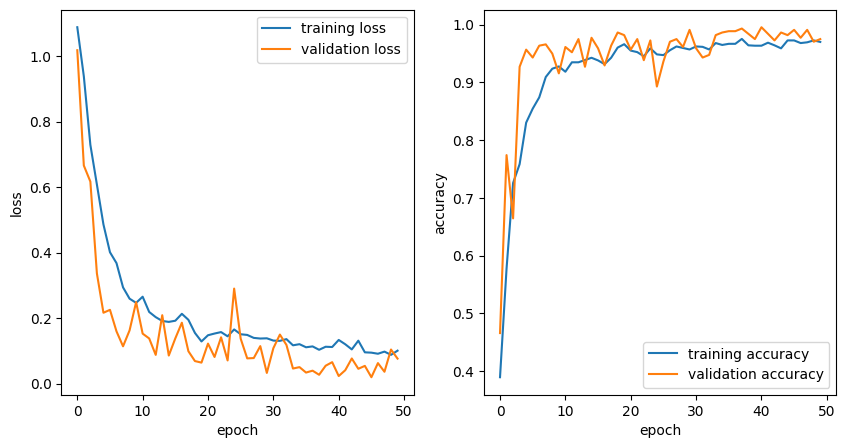

In [9]:
plot_fitting_history(history)

In [10]:
test_gen = create_split_gen(ImageDataGenerator(rescale = 1./255), path= "/home/ocelot/Desktop/CNN_RPS/Archive/test", shuffle=False, label_type="sparse")

Found 219 images belonging to 3 classes.


In [11]:
testLoss, testAccuracy = final_model.evaluate(test_gen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9954 - loss: 0.0221


In [12]:
pred = final_model.predict(test_gen)
report = class_report(pred, test_gen)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [13]:
report["scissors"]

TypeError: string indices must be integers, not 'str'

In [14]:
report["rock"]

{'precision': 1.0,
 'recall': 0.9863013698630136,
 'f1-score': 0.993103448275862,
 'support': 73.0}

In [15]:
report["paper"]

{'precision': 0.9861111111111112,
 'recall': 1.0,
 'f1-score': 0.993006993006993,
 'support': 71.0}

Label predetta: paper Label vera: rock


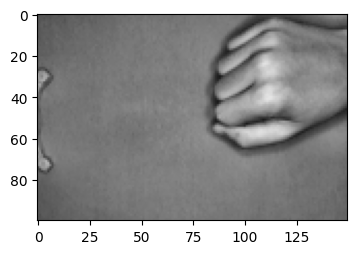

In [14]:
find_errors(pred, test_gen.classes, test_gen)

In [17]:
final_model.save("/home/ocelot/Desktop/secondo.keras")